In [ ]:
!pip -q install transformers

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


## Loading and preprocessing dataset

In [ ]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_colwidth', 2000) # To visualize full output

In [ ]:
#url = 'https://raw.githubusercontent.com/patel-zeel/kdd_data_open/master/SmogTweet500%20-%20210TZ.csv'
url = '/content/SmogTower.csv'
#url2
df_main = pd.read_csv(url)
#df_main = df_main.sample(len(df_main), random_state=0)
#df_main =df_main[df_main['ZLabel'] != 0]
#df_main['ZLabel'] = df_main['ZLabel'].replace({-1:0})
df_main['ZLabel'].value_counts()

 0.0    201
 1.0    188
-1.0     74
Name: ZLabel, dtype: int64

In [ ]:
def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#') # Replace typo with GetOldTweets library
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  tweet = ' '.join(w for w in tweet.split() if w[0] not in ['@']).lower() # Remove mentions
  #tweet = ' '.join(' '.join(segment(w)) if w[0] in ['#'] else w for w in tweet.split()).lower() # segmentation of hashtags
  return tweet

In [ ]:
df_main['Tweet text processed'] = df_main['tweet'].apply(preprocess)
df = df_main
print('before len',len(df))
#df.drop_duplicates(subset='Tweet text processed',inplace=True)
print('after len',len(df))

before len 463
after len 463


In [ ]:
df[['Tweet text processed','ZLabel','TLabel']]

KeyError: ignored

In [ ]:
#hindi_inds = []
X = df['Tweet text processed'].reset_index(drop=True)
y = df['ZLabel'].astype('int').reset_index(drop=True)+1
#X = X.values.tolist()+append1['Tweet text processed'].values.tolist()+append2['Tweet text processed'].values.tolist()
#y = y.values.tolist()+append1['ZLabel'].values.tolist()+append2['ZLabel'].values.tolist()
#X = pd.Series(X)
#X = df['tweet']
#y = pd.Series(y).astype('int')+1
y.value_counts()

## Sentiment preprocess

In [ ]:
import torch
import sys

#### finding out max sent length

In [ ]:
max_len = 0

# For every sentence...
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

#### Tokenize the data

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

# Print sentence 0, now as a list of IDs.
print('Original: ', X.iloc[1])
print('Token IDs:', input_ids[1])

Original:  just wondering: is the beloved #smogtower still functioning? #myrighttobreathe
Token IDs: tensor([  101,  2074,  6603,  1024,  2003,  1996, 11419,  1001, 15488,  8649,
        23196,  2145, 12285,  1029,  1001,  2026, 15950,  3406, 13578,  8988,
         2063,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])


#### Prepare and run the model for CV

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score
kf = KFold(5, shuffle=True, random_state=0)

In [ ]:
import random
import numpy as np
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

ba = [] # Balanced Accuracy for each fold
tl = [] # Train loss at each epoch
bae = [] # Balanced Accuracy at each Epoch
vl = [] # Validation loss at each epoch
tf1 = []
vf1 = []
embeds = []
epochs = 10
batch_size = 32

for train_ind, val_ind in kf.split(input_ids):
  

  # Combine the training inputs into a TensorDataset.
  train_dataset = TensorDataset(input_ids[train_ind], attention_masks[train_ind], labels[train_ind])
  val_dataset = TensorDataset(input_ids[val_ind], attention_masks[val_ind], labels[val_ind])
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = SequentialSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  

  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 3, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = True, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
  

  # Number of training epochs. The BERT authors recommend between 2 and 4. 
  # We chose to run for 4, but we'll see later that this may be over-fitting the
  # training data.

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  # Function to calculate the accuracy of our predictions vs labels
  def flat_accuracy(preds, labels):
      pred_flat = np.argmax(preds, axis=1).flatten()
      labels_flat = labels.flatten()
      return np.sum(pred_flat == labels_flat) / len(labels_flat)

  def format_time(elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      
      # Format as hh:mm:ss
      return str(datetime.timedelta(seconds=elapsed_rounded))

  device = torch.device("cuda")
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()
  
  # For each epoch...
  for epoch_i in range(0, epochs):
      embed_temp = None
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()
      logs = []
      labs = []
      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()        

          loss, logits, hidden = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
          logs.extend(logits.detach().cpu().numpy().argmax(axis=1))
          labs.extend(batch[2])
          if embed_temp == None:
            embed_temp = hidden[12][:,0,:]
          else:
            embed_temp = torch.cat([embed_temp, hidden[12][:,0,:]])
          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()
      embeds.append(embed_temp)
      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      tl.append(avg_train_loss)
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      tf1.append(f1_score(labs, logs, average='macro'))
      print("Macro F1 score", f1_score(labs, logs, average='macro'))
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()
      
      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      val_true = []
      val_pred = []
      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits, hidden) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          #Z# append to val set
          val_true.extend(label_ids.tolist())
          val_pred.extend(logits.argmax(axis=1).tolist())

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      vl.append(avg_val_loss)
      vf1.append(f1_score(val_true, val_pred, average='macro'))

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))


      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )
      
  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  print(classification_report(val_true, val_pred))
  batemp = balanced_accuracy_score(val_true, val_pred)
  print(batemp)
  ba.append(batemp)
  del device
  break


======== Epoch 1 / 10 ========
Training...
Macro F1 score 0.21037581699346408
  Average training loss: 1.07
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.41
  Validation Loss: 0.98
  Validation took: 0:00:00

======== Epoch 2 / 10 ========
Training...
Macro F1 score 0.41915684624017957
  Average training loss: 0.96
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.53
  Validation Loss: 0.89
  Validation took: 0:00:00

======== Epoch 3 / 10 ========
Training...
Macro F1 score 0.606625444928136
  Average training loss: 0.83
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.81
  Validation took: 0:00:00

======== Epoch 4 / 10 ========
Training...
Macro F1 score 0.7478408029878617
  Average training loss: 0.75
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.75
  Validation took: 0:00:00

======== Epoch 5 / 10 ========
Training...
Macro F1 score 0.8155053916274904
 

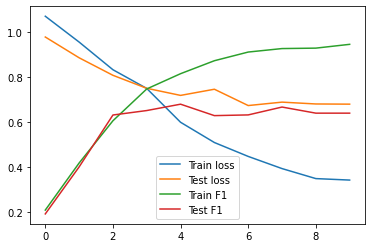

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tl, label='Train loss')
plt.plot(vl, label='Test loss')
plt.plot(tf1, label='Train F1')
plt.plot(vf1, label='Test F1')
plt.legend()

In [ ]:
for i in range(10):
  print(embeds[i].shape)

torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])
torch.Size([370, 768])


### TSNE

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

In [ ]:
X_2d = []
tsne = TSNE(n_components=2, random_state=0)
for embed in embeds:
  X_2d.append(tsne.fit_transform(embed.detach().cpu().numpy()))

In [ ]:
labels = df['ZLabel'].iloc[train_ind]

In [ ]:
X_2d[0].shape

(370, 2)

In [ ]:
labels.value_counts()[-1]

60

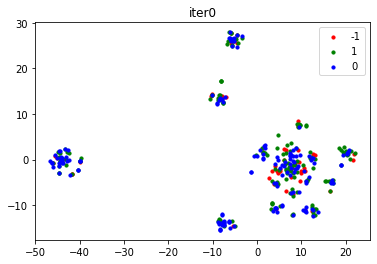

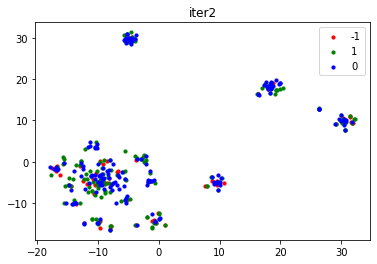

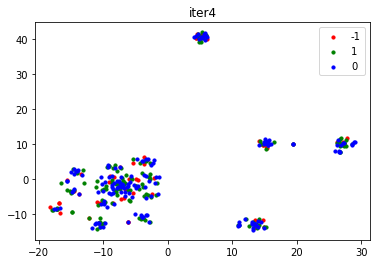

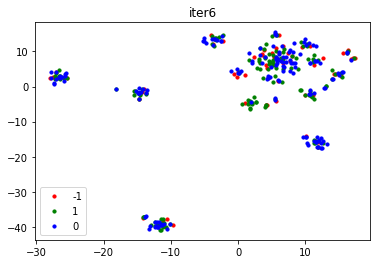

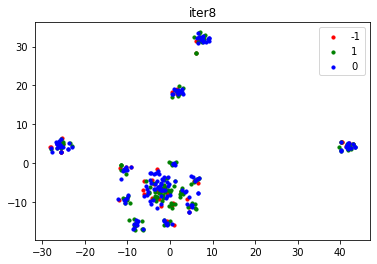

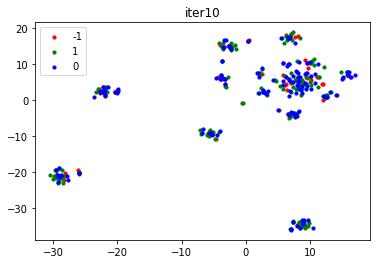

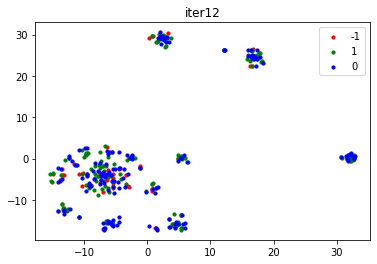

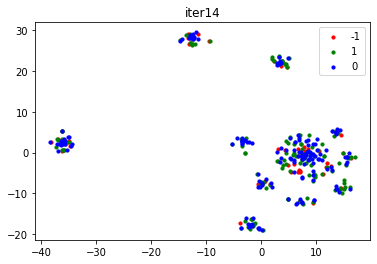

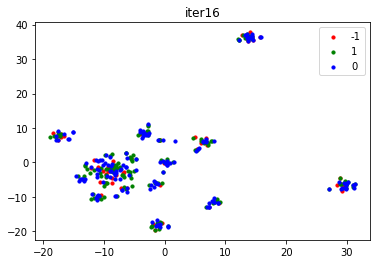

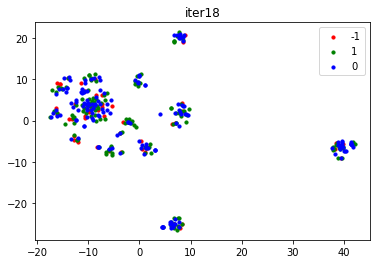

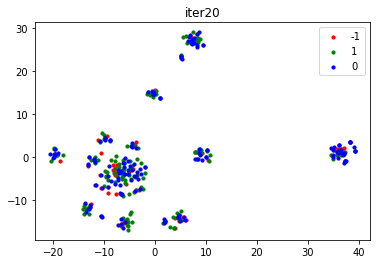

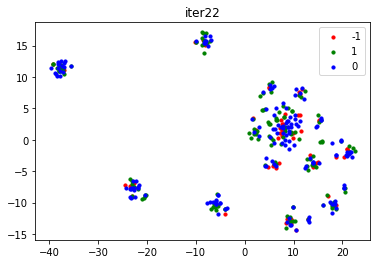

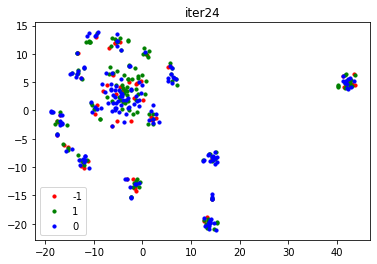

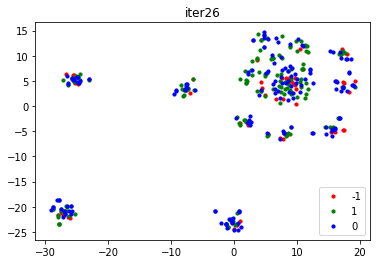

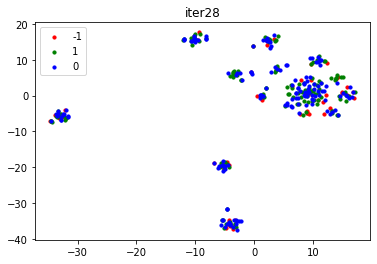

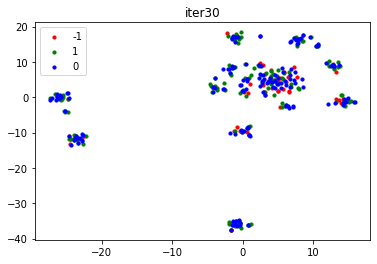

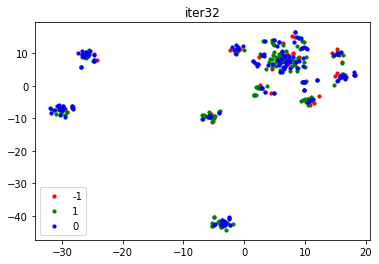

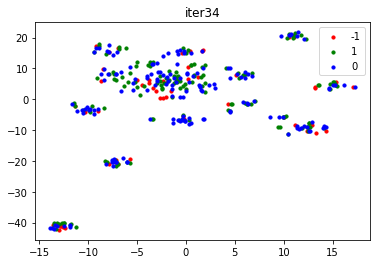

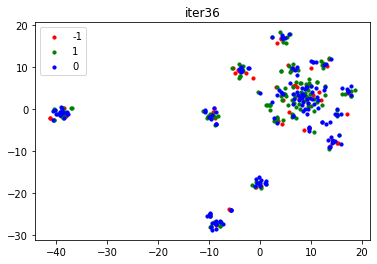

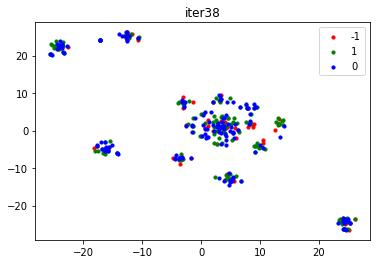

In [ ]:
for iteration in range(0,10,1):
  plt.figure()
  neg = []
  nut = []
  pos = []
  for i,l in enumerate(labels):
    if l == -1:
      neg.append([X_2d[iteration][i,0], X_2d[iteration][i,1]])
    elif l == 1:
      pos.append([X_2d[iteration][i,0], X_2d[iteration][i,1]])
    elif l == 0:
      nut.append([X_2d[iteration][i,0], X_2d[iteration][i,1]])
  neg = np.array(neg).T
  pos = np.array(pos).T
  nut = np.array(nut).T
  plt.scatter(neg[0,:], neg[1,:], color='r', label='-1', s=10)
  plt.scatter(pos[0,:], pos[1,:], color='g', label='1', s=10)
  plt.scatter(nut[0,:], nut[1,:], color='b', label='0', s=10)
  plt.legend()
  plt.title('iter'+str(iteration))
  plt.savefig('ST'+str(iteration).zfill(2))
  plt.show()

In [ ]:
from PIL import Image
images = []
for iteration in range(0,40,2):
    images.append(Image.open('ST'+str(iteration).zfill(2)+'.png'))
images[0].save('movie.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=1000, loop=0)

In [ ]:
fig, ax = plt.subplots()

def update(iteration):
    ax.cla()
    for i,l in enumerate(labels):
      if l == -1:
        ax.scatter(X_2d[iteration][i,0], X_2d[iteration][i,1], color='r',label='-1')
      elif l == 1:
        ax.scatter(X_2d[iteration][i,0], X_2d[iteration][i,1], color='g',label='1')
      elif l == 0:
        ax.scatter(X_2d[iteration][i,0], X_2d[iteration][i,1], color='b',label='0')
    fig.tight_layout()
#plt.legend([-1,1,0])
anim = FuncAnimation(fig, update, frames=np.arange(0, 10, 1), interval=1000)
plt.close()
rc('animation', html='jshtml')
anim

In [ ]:
anim.save('new.mp4')

### Visualize losses and accuracy over 5fold

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1,figsize=(10,15))
for i in range(5):
  ax[i].plot(range(30),tl[30*i:30*(i+1)],label='train loss')
  ax[i].plot(range(30),vl[30*i:30*(i+1)],label='val loss')
  ax[i].plot(range(30),bae[30*i:30*(i+1)],label='balanced accuracy')
  ax[i].set_xlabel('epoch')
  ax[i].legend()

Text(0.5, 1.0, 'average 5fold balanced accuracy over 30 epochs')

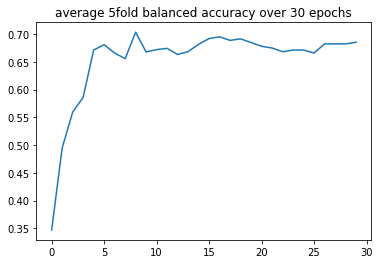

In [ ]:
plt.plot(np.array(bae).reshape(5,30).mean(axis=0))
plt.title('average 5fold balanced accuracy over 30 epochs')

In [ ]:
dfr = pd.DataFrame()
dfr['text'] = df['Tweet text processed'].iloc[val_ind].values
dfr['truth'] = pd.Series(val_true).replace({0:'-Ve',1:'Neu',2:'+Ve'}) 
dfr['pred'] = pd.Series(val_pred).replace({0:'-Ve',1:'Neu',2:'+Ve'})

### Visualize wrongly predicted results

In [ ]:
dfr[dfr['truth'] != dfr['pred']]

,text,truth,pred
0,delhi gets first smog tower to combat air pollution. this pilot project to consider the efficacy of smog towers is being undertaken by the iit bombay in collaboration with iit delhi and the university of minnesota. …,Neu,+Ve
5,delhi gets first smog tower to combat air pollution - delhi news - hindustan times …,+Ve,Neu
6,"❓❗️❓❗️ ""the vertical smog tower will house a 'breathing tower', designed to purify air by using plants."" bengaluru: smog tower, waterfall on cards for cubbon park",+Ve,Neu
8,😷need emissions control at source & not smog towers to tackle please rt to spread the word. watch the video 👇 …,-Ve,+Ve
9,we should install one next to the smog tower in delhi. that it will keep the lungs pristine white forever,+Ve,Neu
10,smog tower would love your feedback. post a review to our profile. …,Neu,-Ve
12,and what's our beloved doing at lajpat nagar ? …,+Ve,Neu
13,*note: installing air purifiers won't reduce citywide delhi gets first smog tower today: 5 things about the air purifier at lajpat nagar,-Ve,+Ve
14,"in jan a smog tower was installed in lajpat nagar, delhi. our analysis find that its influence area would be limited within a 50-m radius. watch the video 👇 …",-Ve,Neu
16,patna need smog tower.,+Ve,Neu
